In [ ]:
from pymongo import MongoClient
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

%matplotlib inline


In [8]:
### The dataframe df_surface_parking_sensors is created by exporting the surface_parking_sensors bson
### created by looping through the mongo document 
df_surface_parking_sensors = pd.read_csv('synchronicity_parking.csv')

### turn date related columns into datetime
df_surface_parking_sensors['dc:modified'] =  pd.to_datetime(df_surface_parking_sensors['dc:modified'],
                                                          format='%Y-%m-%dT%H:%M:%S.%f')

### In case there's a need for time conversion (not necessary in this case)
# df_surface_parking_sensors['dc:modified'] = df_surface_parking_sensors['dc:modified'].dt.tz_localize('UTC').dt.tz_convert('Europe/Madrid')

### change column dtype form object to number
df_surface_parking_sensors['ayto:status'] = pd.to_numeric(df_surface_parking_sensors['ayto:status'])

### set the datetime index
df_surface_parking_sensors.set_index('dc:modified',inplace=True)

### create two extra columns using the datetime object: hour of day and weekday. This will help us during plotting
df_surface_parking_sensors['hour'] = df_surface_parking_sensors.index.hour
df_surface_parking_sensors['day'] = df_surface_parking_sensors.index.weekday



In [11]:
### Here we will perform a spatial join of the parking sensors with the road segments (the aggregated entities)
### First create a shapely point geometry using the coordinates
geometry = [Point(xy) for xy in zip(df_surface_parking_sensors['ayto:longitude'],
                                    df_surface_parking_sensors['ayto:latitude'])]

### Define the coordinate system (WGS 84)
crs = {'init': 'epsg:4326'}

### Create a geodataframe using the geometry
gdf = gpd.GeoDataFrame(df_surface_parking_sensors, crs=crs, geometry=geometry)

In [13]:
### These are the 'aggregated entities' I created.They are basically polygon geojsons that contain the road segments 

gdf1 = gpd.read_file('/Users/tbantis/Desktop/pr1/Thanos data/Synchronicity/calle_de_ataulfo_argenta.geojson')
gdf2 = gpd.read_file('/Users/tbantis/Desktop/pr1/Thanos data/Synchronicity/calle_de_bonifaz.geojson')
gdf3 = gpd.read_file('/Users/tbantis/Desktop/pr1/Thanos data/Synchronicity/calle_de_hernan_cortes.geojson')
gdf4 = gpd.read_file('/Users/tbantis/Desktop/pr1/Thanos data/Synchronicity/calle_de_penna_herbosa_daoiz_y_velarde.geojson')
gdf5 = gpd.read_file('/Users/tbantis/Desktop/pr1/Thanos data/Synchronicity/calle_de_santa_lucia.geojson')
gdf6 = gpd.read_file('/Users/tbantis/Desktop/pr1/Thanos data/Synchronicity/calle_de_vega.geojson')
gdf7 = gpd.read_file('/Users/tbantis/Desktop/pr1/Thanos data/Synchronicity/calle_dela_gandara.geojson')



In [27]:
### This will create the proportion of free versus occupied dataframe for each time of day and 
### aggregated entity. It will contain three columns: the proportion (vals) the time of day (tod) 
### and location (the aggtegated entity)
a = pd.DataFrame(columns = ['vals', 'tod', 'location'])


### Looping through the parking sensor identifiers.
for k in df_surface_parking_sensors['dc:identifier'].unique():
    print('Sensor id: ', k)
    
    ### create a temporary dataframe containing the hour, weekday, parking status and location
    tempdf = df_surface_parking_sensors[df_surface_parking_sensors['dc:identifier']==k][['hour','day',
                                                                                         'ayto:status',
                                                                                        'ayto:longitude',
                                                                                        'ayto:latitude']]
    ### sort it by hour
    tempdf.sort_values(by='hour')
    
    ### Wrap the location in a shapely object
    point = Point((tempdf['ayto:longitude'].iloc[0],
                      tempdf['ayto:latitude'].iloc[0]))
    
    ### Check which entity the parking sensor falls to get the location code
    if point.within(gdf1.geometry[0]):
        loc = 'calle_de_ataulfo_argenta'
    if point.within(gdf2.geometry[0]):
        loc = 'calle_de_bonifaz'
    if point.within(gdf3.geometry[0]):
        loc = 'calle_de_hernan_cortes'        
    if point.within(gdf4.geometry[0]):
        loc = 'calle_de_penna_herbosa_daoiz_y_velarde'          
    if point.within(gdf5.geometry[0]):
        loc = 'calle_de_santa_lucia' 
    if point.within(gdf6.geometry[0]):
        loc = 'calle_de_vega' 
    if point.within(gdf7.geometry[0]):
        loc = 'calle_dela_gandara' 
                
                        
    ### Get the  unique hours of interaction of parking sensors. This will be used as a looping index
    tod = tempdf.drop_duplicates().groupby(['hour','ayto:status']).count().reset_index().hour.unique()
    vals = []
    location = []
    
    ### Groupby hour and status to get the counts of parking status changes by hour. More 1's in an indication of busy-ness
    temp = tempdf.drop_duplicates().groupby(['hour','ayto:status']).count().reset_index()
    
    ### Loop through those hours
    for i in tod:
        
        temptod = i
        temp0 = 0
        temp1 = 0
        
        ### Get the number of times the parking status has changed for a specific timo of day and sensor from the groupby object
        for j in range(0, len(temp)):     
            
            if (temp.iloc[j].hour == temptod and temp.iloc[j]['ayto:status'] == 0):
                temp0 = temp.iloc[j].day
            if (temp.iloc[j].hour == temptod and temp.iloc[j]['ayto:status'] == 1):
                temp1 = temp.iloc[j].day
        
        ### Calculate the proportion a parking spot was occupied versus free
        vals.append(temp1/(temp1+temp0))
        
        ### Append the entity within which the parking sensor falls in
        location.append(loc)
    
    
    ### Create a dataframe with the variables and append it in the grand dataframe
    b = pd.DataFrame(columns = ['vals', 'tod', 'location'])
    b['vals'] = vals
    b['tod'] = tod
    b['location'] = location
    
    a = a.append(b)

Sensor id:  3614
Sensor id:  3615
Sensor id:  3646
Sensor id:  3629
Sensor id:  3647
Sensor id:  3912
Sensor id:  3640
Sensor id:  3648
Sensor id:  3720
Sensor id:  3751
Sensor id:  3719
Sensor id:  3922
Sensor id:  3638
Sensor id:  3914
Sensor id:  3641
Sensor id:  3635
Sensor id:  3904
Sensor id:  3903
Sensor id:  3607
Sensor id:  3762
Sensor id:  3869
Sensor id:  3776
Sensor id:  3803
Sensor id:  3821
Sensor id:  3902
Sensor id:  3661
Sensor id:  3668
Sensor id:  3882
Sensor id:  3657
Sensor id:  3654
Sensor id:  3759
Sensor id:  3866
Sensor id:  3606
Sensor id:  3895
Sensor id:  3862
Sensor id:  3891
Sensor id:  3758
Sensor id:  3600
Sensor id:  3728
Sensor id:  3749
Sensor id:  3827
Sensor id:  3872
Sensor id:  3893
Sensor id:  3871
Sensor id:  3601
Sensor id:  3896
Sensor id:  3619
Sensor id:  3800
Sensor id:  3602
Sensor id:  3855
Sensor id:  3775
Sensor id:  3870
Sensor id:  3884
Sensor id:  3612
Sensor id:  3830
Sensor id:  3825
Sensor id:  3826
Sensor id:  3723
Sensor id:  36

/Users/tbantis/Desktop/pr3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Time of day')

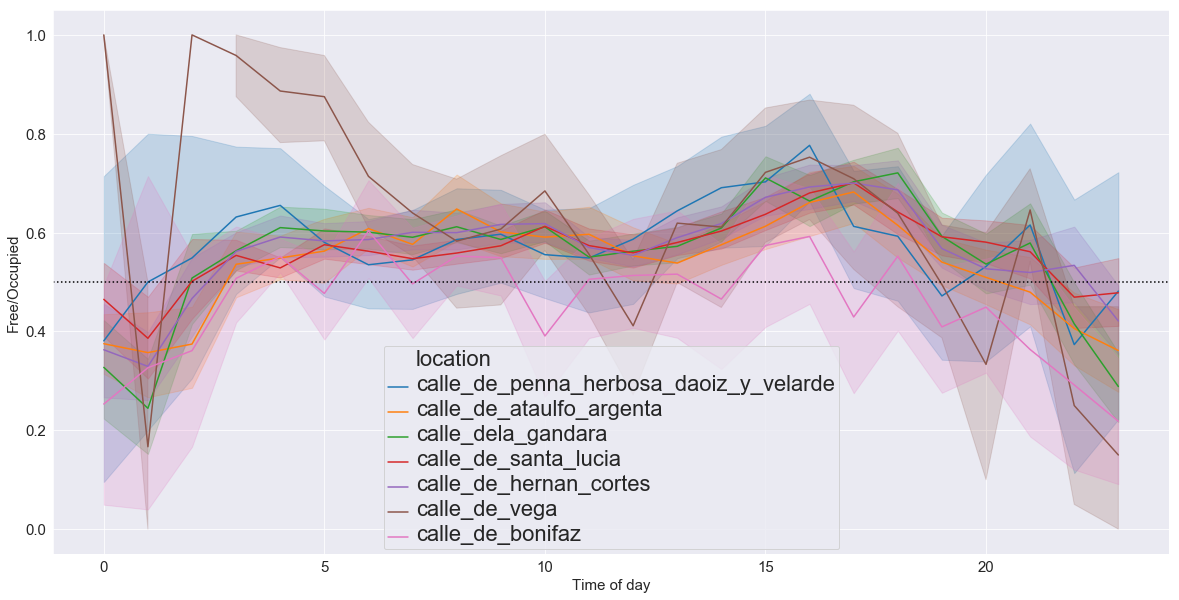

In [28]:
### Plot the result

fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("darkgrid")
sns.lineplot(x= 'tod', y='vals', hue="location",data=a)
plt.axhline(y=0.5, color='black', linestyle=':')
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='32') # for legend title
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_ylabel('Free/Occupied', fontsize=15)
ax.set_xlabel('Time of day', fontsize=15)


In [ ]:
### Next, the calculation of how much time a parking spot is occupied throughout the day is given. This will be presented
### in the heatmap

### This loop takes a long time! 
parking = pd.DataFrame(columns = ['id','day', 'weekday', 'tod', 'remained_occupied_for'])
for j in df_surface_parking_sensors['dc:identifier'].unique():
    
    print(j)
    temp = df_surface_parking_sensors[df_surface_parking_sensors['dc:identifier']==j].reset_index()
    temp['dc:modified'] =  pd.to_datetime(temp['dc:modified'],
                                                              format='%Y-%m-%dT%H:%M:%S.%f')
    ix = 0
    
    for i in range(1, len(temp)):
        if temp.iloc[i]['dc:modified'].day == temp.iloc[i-1]['dc:modified'].day:
            if temp.iloc[ix]['ayto:status'] != temp.iloc[i]['ayto:status']:
                diff = (temp.iloc[i]['dc:modified'] - temp.iloc[ix]['dc:modified']).seconds/60
                ix = i
                if temp.iloc[ix]['ayto:status'] == 1:
                    parking.loc[len(parking)]  = [j, temp.iloc[i]['dc:modified'].day,
                                                  temp.iloc[i]['dc:modified'],
                                                 temp.iloc[i]['dc:modified'].hour,
                                                 diff]
                
        else:
            ix = i
 
    

In [41]:
### Subset the parking spots that remained occupied for less than 8 hours 
parking['Date'] = pd.to_datetime(parking['weekday'])
t_parking = parking.set_index('Date')
t_parking['weekday'] = t_parking.index.weekday
t_parking = t_parking[t_parking.remained_occupied_for < 8]

Text(0.5, 233.08, 'Time of day')

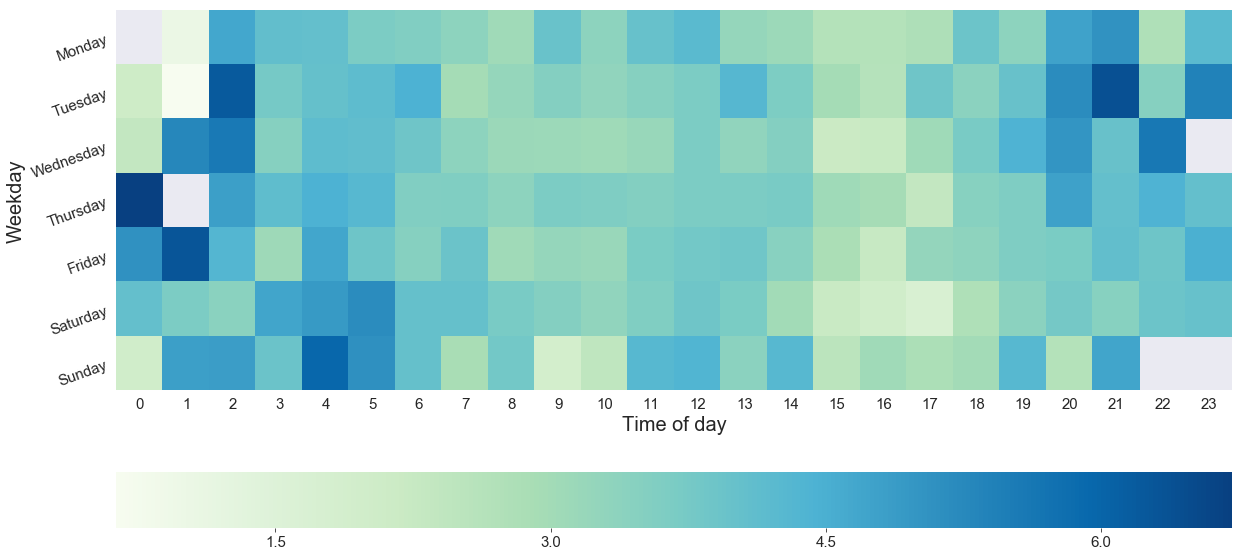

In [45]:
### Create the heatmap

fig, ax = plt.subplots(figsize=(20, 10))

heat = pd.pivot_table(t_parking[['weekday', 'tod', 'remained_occupied_for']],
               values='remained_occupied_for', index='weekday', columns='tod')

ax = sns.heatmap(heat, cmap="GnBu",cbar_kws = dict(use_gridspec=False,location="bottom"))

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
ax.set_yticklabels(days)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15,rotation = 20)
ax.set_ylabel('Weekday', fontsize=20)
ax.set_xlabel('Time of day', fontsize=20)

In [46]:
### Next is a histogram of proportion of spaces being used/taken (proxy=busy for more than 45 minutes)
vals = []
for j in list(range(24)):
    temp = 0
    for name, group in  parking[parking['remained_occupied_for'] > 45].groupby(['tod', 'id']):
        if name[0] == j:
            temp = temp+1
    vals.append(temp)
    

Text(0.5, 0, 'Time of day')

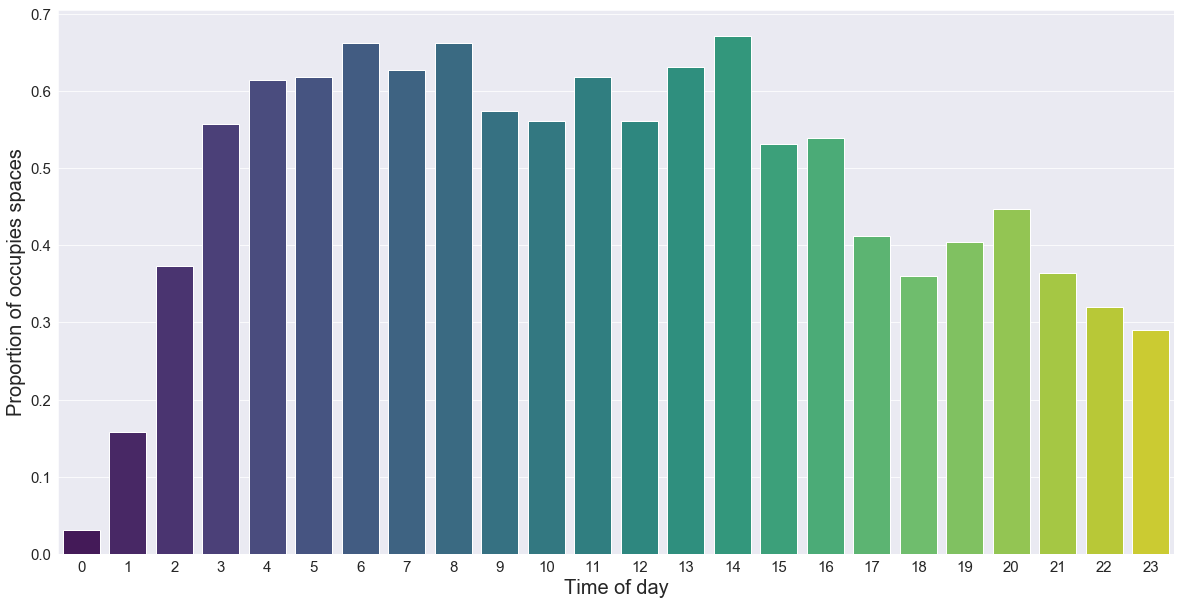

In [49]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.set_style("darkgrid")
plt.bar(x = list(range(24)),
        height = np.array(vals)/len(parking.id.unique()))
sns.barplot(x=list(range(24)), y=np.array(vals)/len(parking.id.unique()),palette = 'viridis')
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_ylabel('Proportion of occupies spaces', fontsize=20)
ax.set_xlabel('Time of day', fontsize=20)